In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 

In [2]:
df_clean = pd.read_pickle("../data/processed/df_clean.pkl")
df_genres = pd.read_pickle("../data/processed/df_genres.pkl")
df_companies = pd.read_pickle("../data/processed/df_companies.pkl")

In [3]:
# For the modeling phase of this project, we will focus on profit rather than ROI.
# While ROI provides a ratio of return, profit is a more concrete metric for stakeholders,
# as it reflects the actual financial gain a film can generate. This makes it more directly useful for 
# decision-making in budgeting, production, and investment strategies. 

# In order to prepare the data for modeling, we will make a model-ready DataFrame, by encoding the categorical variables 
# such as 'genres' and 'production_companies'. This step involves encoding and then merging these encoded features 
# back with the main dataset.

In [4]:
# To ensure the reliability of our profit-based model, we apply the same outlier treatment strategy used in our earlier analysis.
# This involves capping extreme values in the 'profit' variable, which helps reduce the impact of outliers that could distort the model's performance.

upper_limit = df_clean['profit'].quantile(0.99)
df_clean_capped = df_clean[df_clean['profit'] <= upper_limit].copy()

In [5]:
top_genres = df_genres['genres'].value_counts().head(6).index.tolist() # We limit to the top 6 most frequent genres
# to ensure model interpretability. 
df_genres_top = df_genres[df_genres['genres'].isin(top_genres)].copy()
genre_dummies = pd.get_dummies(df_genres_top['genres'])

df_genres_encoded = pd.concat([df_genres_top[['id']], genre_dummies], axis=1)
df_genres_encoded = df_genres_encoded.groupby('id').sum().reset_index()

In [6]:
# For the company we will only take the first company/ main company of each movie.

df_main_company = df_companies.groupby('id').first().reset_index()

top_companies = df_main_company['production_companies'].value_counts().head(5).index.tolist() # Here we limit to the top 5
# most frequent companies for the same purpose of genres. 
df_main_company['main_company'] = df_main_company['production_companies'].where(df_main_company['production_companies'].isin(top_companies), 'other')

company_dummies = pd.get_dummies(df_main_company['main_company'])

df_company_encoded = pd.concat([df_main_company[['id']], company_dummies], axis=1)

In [7]:
# Merging for a model-ready DataFrame.
df_model = df_clean_capped[['id', 'budget', 'revenue', 'runtime', 'release_date', 'profit']].copy()
df_model['release_month'] = df_model['release_date'].dt.month

In [8]:
df_model = df_model.merge(df_genres_encoded, on='id', how='left')
df_model = df_model.merge(df_company_encoded, on='id', how='left')

In [9]:
df_model.fillna(0, inplace=True)

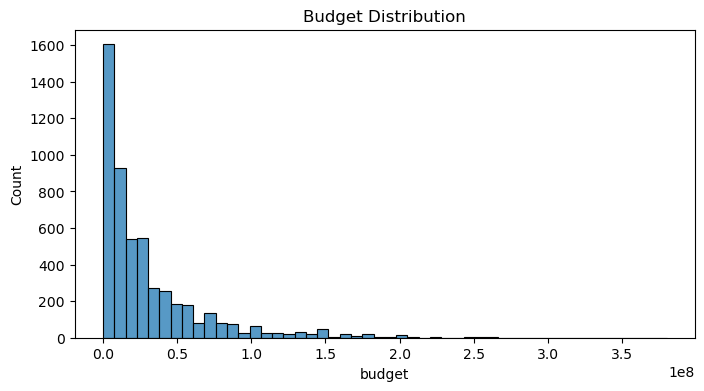

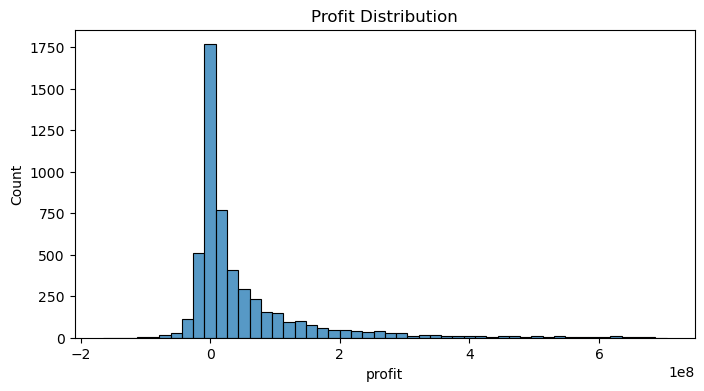

In [10]:
# We observed previously that budget was strongly right-skewed.
# Let's recheck it and examine profit as well.
plt.figure(figsize=(8, 4))
sns.histplot(df_model['budget'], bins=50)
plt.title("Budget Distribution")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_model['profit'], bins=50)
plt.title("Profit Distribution")
plt.show()

In [11]:
# As we suspected, they are extremely right_skewed and we will need to apply log transformation for the model.
# To be able to apply log transformation on profit we have to get rid of negative values.
print((df_model['profit'] < 0).sum())   
print(df_model['profit'].isna().sum())   

1565
0


In [12]:
df_model = df_model[df_model['profit'] >= 0].copy()
df_model['log_budget'] = np.log1p(df_model['budget'])
df_model['log_profit'] = np.log1p(df_model['profit'])

In [13]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3675 entries, 0 to 5237
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   id                                      3675 non-null   object        
 1   budget                                  3675 non-null   float64       
 2   revenue                                 3675 non-null   float64       
 3   runtime                                 3675 non-null   float64       
 4   release_date                            3675 non-null   datetime64[ns]
 5   profit                                  3675 non-null   float64       
 6   release_month                           3675 non-null   int32         
 7   Action                                  3675 non-null   float64       
 8   Adventure                               3675 non-null   float64       
 9   Comedy                                  3675 non-null   f

In [14]:
# All is ready, we can now fit the regression model and evaluate its performance.
X = df_model[['log_budget', 'release_month', 'runtime', 'Action', 'Adventure', 'Comedy', 'Drama', 'Romance', 'Columbia Pictures', 'New Line Cinema', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Universal Pictures']]
X = sm.add_constant(X)
X = X.apply(pd.to_numeric)

y = df_model['log_profit']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_profit   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     166.6
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        16:02:23   Log-Likelihood:                -7102.6
No. Observations:                3675   AIC:                         1.423e+04
Df Residuals:                    3661   BIC:                         1.432e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [15]:
# The adjusted R-Squared value of 0.369 suggest that approximately 37% of the variance in log profit is explained
# by our model. This is quite a modest level of explanation, but reasonable given the complexity of movie profitability,
# and the fact that we seleted just a few variables not all genres, companies, countries and so on.

# For the p-values we can observe that some variables are more significant than others. 
# For instance, we see that the budget is highly significant, while runtime, genres like Comedy and production companies
# like New Line Cinema are clearly not significant. 

# To potentially improve the model we could remove features with high p-values and rerun the regression to 
# see if the model fit improves. 

In [16]:
# Considering that the variables we are removing have very high p-values, and that our objective is focused 
# on extracting insights rather than making predictions, we will drop them all at once to simplify the model
# and improve interpretability.

X_refined = df_model[['log_budget', 'release_month', 'Action', 'Adventure', 'Drama', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Universal Pictures']]
X_refined = sm.add_constant(X_refined)
X_refined = X_refined.apply(pd.to_numeric)

y = df_model['log_profit']

model_refined = sm.OLS(y, X_refined).fit()

print(model_refined.summary())

                            OLS Regression Results                            
Dep. Variable:             log_profit   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     270.4
Date:                Fri, 16 May 2025   Prob (F-statistic):               0.00
Time:                        16:02:27   Log-Likelihood:                -7104.2
No. Observations:                3675   AIC:                         1.423e+04
Df Residuals:                    3666   BIC:                         1.428e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [17]:
# The Adjusted R-Squared value remains virtually unchanged after taking out the higher p-values features
# and simplifying the model. Further variable reduction offers little gain and may remove useful context.
# We will consider this our final regression model. 

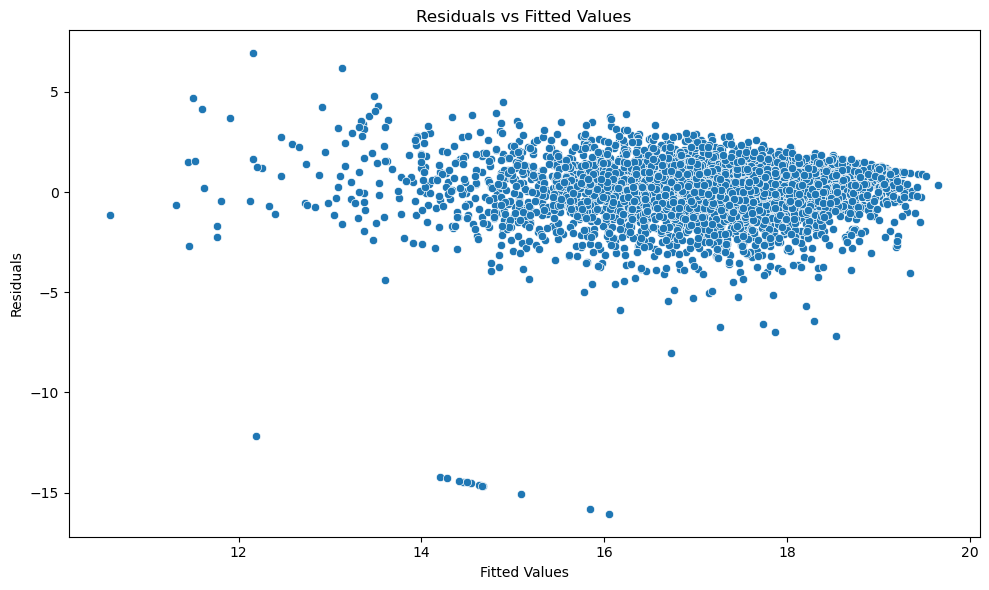

In [18]:
# Now we to check linearity and homoscedasticity. We can plot them to verify the assumptions of linear regression
# are satisfied. 

residuals = model_refined.resid
fitted = model_refined.fittedvalues

plt.figure(figsize=(10,6))
sns.scatterplot(x=fitted, y=residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

In [19]:
# The residuals are generally centered around 0 with no strong curve, suggesting the validation 
# of the linearity assumption. 
# However, we see a spread of residuals, indicating some heteroscedasticity.
# This means the model may be less accurate in some areas but overall remains stable and interpretable.

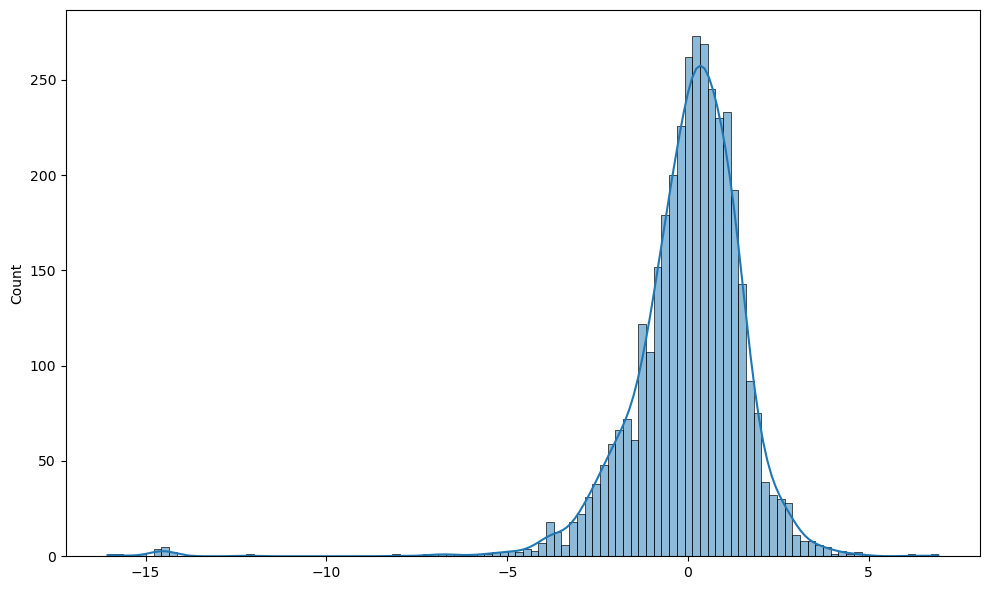

In [20]:
# To further validate the model we can also plot the distribution of residuals.

plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.tight_layout()
plt.show()

In [21]:
# The histogram shows that residuals are approximately normally distributed, with a slight left 
# skew caused by underperforming outliers.
# This supports the assumption of normality required. 

In [22]:
# Final note: 
# While this notebook focused on building a regression model to understand what drives a movie's profit,
# a possible extension would be to also add a classification model predicting whether a movie 
# will be profitable or not. This could support investment decisions.
# This could be explored in a future iteration or used alongside dashboard visualizations.